<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Double_Well_2D/Models/%5BFINAL%5Dboundary_adapted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Install FEniCS and mshr
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [52]:
# Imports & FP64
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from fenics import *
import mshr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

# Solving for the MET of a given SDE in an ellipse with "Boundary Adapted PINNs": comparison with FEM solution

## 1) Setup

Let $a=2$, $b=1.5$, and $
\Omega := \{ (x,y)\in\mathbb{R}^2 : (x/2)^2 + (y/1.5)^2 < 1 \}$ be the ellipse centered at the origin with semi-axes $a$ (along $x$) and $b$ (along $y$). We consider a process driven by the double-well potential

$$
\Phi(x,y):= A\Bigl( 1-\exp\Bigl(-\frac{(x-1)^2+(y-0.5)^2}{\nu^2}\Bigr)\Bigr)
\Bigl( 1-\exp\Bigl(-\frac{(x+1)^2+(y+0.5)^2}{\nu^2}\Bigr)\Bigr),
$$  
with parameters $A>0$ (which controls the barrier height) and $\nu>0$ (which controls the width of the wells). Its associated drift is given by the negative gradient,
$$
b(x,y)= -\nabla\Phi(x,y)= \begin{pmatrix} b_1(x,y) \\ b_2(x,y) \end{pmatrix}.
$$

The stochastic differential equation solved by our process takes the form
$$
\begin{cases}
dX_t = b(X_t)\,dt + \sigma(X_t)\,dW_t,\\
X_0 = x\in\Omega,
\end{cases}
$$  
where the diffusion matrix is chosen as  
$$
\sigma(x,y)= \begin{pmatrix}
\sqrt{2\epsilon} & 0 \\
0 & \sqrt{\epsilon}
\end{pmatrix}
$$  
for some $\epsilon>0$, and $W_t$ is a two-dimensional standard Brownian motion.

For all $x\in\Omega$, we define the exit time
$$
T(x):=\inf\{t\ge 0: X_t\in\partial\Omega\},
$$  
and denote by
$$
\tau(x):=\mathbb{E}[T(x)]
$$  
its first moment (the mean exit time).

In this setting, one can show that $\tau$ is the (unique) solution of the boundary value problem
$$
\begin{cases}
-\mathcal{L} u(x) = 1 \quad \text{for all } x\in\Omega,\\[1mm]
u(x)= 0 \quad \text{for all } x\in\partial\Omega,
\end{cases}
$$  
where the infinitesimal generator $\mathcal{L}$ is given by
$$
\mathcal{L} u(x) = \epsilon\, u_{xx}(x) + \frac\epsilon2\, u_{yy}(x) + b_1(x,y)\, u_x(x) + b_2(x,y)\, u_y(x).
$$

**Derivation of the Weak Formulation:**

Multiplying the strong form of the PDE
$$
\epsilon\, u_{xx} + \frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y = -1 \quad \text{in } \Omega,
$$  
by a test function $v\in H^1_0(\Omega)$ and integrating over $\Omega$, we obtain
$$
\int_\Omega \Bigl[ \epsilon\, u_{xx} +\frac\epsilon2\, u_{yy} + b_1\, u_x + b_2\, u_y \Bigr] v\,dx\,dy = -\int_\Omega v\,dx\,dy.
$$  
Integration by parts on the second derivative terms (with $v=0$ on $\partial\Omega$) yields
$$
\int_\Omega \Bigl(\epsilon\, u_x\, v_x + \frac\epsilon2\, u_y\, v_y \Bigr) dx\,dy - \int_\Omega \Bigl( b_1\, u_x + b_2\, u_y \Bigr) v\,dx\,dy = \int_\Omega v\,dx\,dy.
$$  
This is the weak formulation that we discretize using a Galerkin finite element method.

## Approximating the true solution with FEM

In [53]:

# Parameters controlling the double-well potential and diffusion.
#numpy version
A_np = 5.0      # Barrier height for the double-well potential
nu_np = 0.2     # Width parameter of the wells in the potential
eps_np = 0.9    # Diffusion parameter
#fenics version
A = Constant(A_np)
nu = Constant(nu_np)
epsilon = Constant(eps_np)

# Create the elliptical domain Omega
a = 2.0
b = 1.5
domain = mshr.Ellipse(Point(0.0, 0.0), a, b)
mesh = mshr.generate_mesh(domain, 64)

# FE function space and boundary conditions
V = FunctionSpace(mesh, "CG", 1)

# Homogeneous Dirichlet BC (u = 0 on the boundary)
u_D = Constant(0.0)
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Define the double-well potential and drift field
# using the spatial coordinates (x,y) from the mesh
x_coord = SpatialCoordinate(mesh)

# Double-well potential defined by:
#   Φ(x,y) = A [1 - exp(-((x-1)²+(y-0.5)²)/ν²)] [1 - exp(-((x+1)²+(y+0.5)²)/ν²)]
Phi = A * (1 - exp(-(((x_coord[0]-1)**2 + (x_coord[1]-0.5)**2) / (nu**2)))) \
        * (1 - exp(-(((x_coord[0]+1)**2 + (x_coord[1]+0.5)**2) / (nu**2))))

# The drift b(x,y) is the negative gradient of the potential.
db = -grad(Phi)
b1 = db[0]
b2 = db[1]

# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)

# The weak formulation reads:
# (ε u_x v_x + (ε/2) u_y v_y) dx - (b₁ u_x + b₂ u_y) v dx = ∫_Ω v dx

a_form = (epsilon * u.dx(0) * v.dx(0) + (epsilon/2) * u.dx(1) * v.dx(1)
          - (b1 * u.dx(0) + b2 * u.dx(1)) * v) * dx
L_form = v * dx

# Solve the problem
u_sol = Function(V)
solve(a_form == L_form, u_sol, bc)

# ------------------------
# Now u_h is the finite element solution (function of x and y)
# Example: Evaluating the solution at a specific point (x0, y0):
pt = (0.0, 0.0)  # Example point at the center of the domain
value_at_pt = u_sol(pt)
print("The solution u_sol at point {} is: {}".format(pt, value_at_pt))

The solution u_sol at point (0.0, 0.0) is: 7.788402053371888


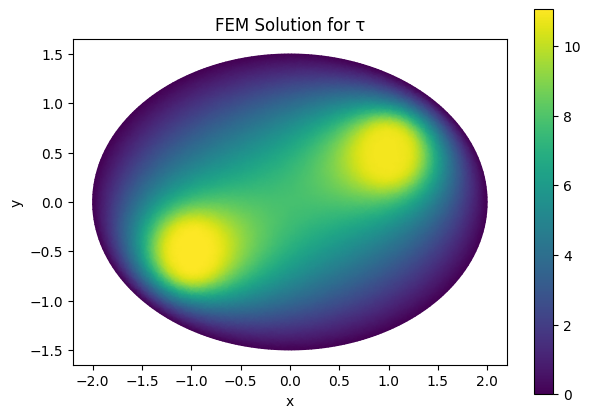

In [54]:

# Plot the solution (using FEniCS plot backend which works in Colab with matplotlib)
plt.figure(figsize=(7, 5))
p = plot(u_sol, title="FEM Solution for τ", mode="color")
plt.colorbar(p)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# plotting the mesh to see how the ellipse was discretized
# plt.figure(figsize=(7, 5))
# plot(mesh)
# plt.title("Mesh for the Elliptical Domain")
# plt.show()

## Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{\omega(x)}{\sqrt{\omega(x)^2 + \|\nabla\omega(x)\|^2}},$$
where
$$\omega(x,y) = 1 - \left(\frac{x}{a}\right)^2 - \left(\frac{y}{b}\right)^2,\ \ \text{and }\ \ \|\nabla\omega(x,y)\|^2 = \left(\frac{2x}{a^2}\right)^2 + \left(\frac{2y}{b^2}\right)^2 $$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}_\varphi}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$, and the hypothesis space is given by
$$\mathcal{NN}_\varphi:=\left\{x\mapsto \varphi(x) \cdot T_L\circ \sigma \circ T_{L-1}\circ\cdots\circ \sigma\circ T_1 (x)\right\}, $$
for
$$T_\ell : \mathbb{R}^{\ell-1}\to\mathbb{R}^\ell $$
affine-linear maps of appropriate input-output dimensions, where
$$\sigma :x \mapsto \begin{cases}x^2 &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} \quad \text{OR }\ \ \sigma : x\mapsto \operatorname{tanh}(x),$$
is either the ReQU or hyperbolic tangent activation function, which is understood element-wise when applied to vectors.

In [55]:
# defining PINN w/ matching boundary condition
power = None #exponent k for relu^k, none for tanh
width = 30
depth = 3
gain = 2.0 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)

#define the smooth distance approximation
def smooth_distance(x, a=a, b=b):
    omega_x = 1 - (x[:,0]/a)**2 - (x[:,1]/b)**2
    grad_omega_x_sq = (2 * x[:,0]/a**2)**2 + (2 * x[:,1]/b**2)**2
    denominator = torch.sqrt(omega_x**2 + grad_omega_x_sq)
    return omega_x/denominator

#define hypothesis space
class BoundaryPINN(nn.Module):
    def __init__(self, power = power, width = width, depth = depth):
        super(BoundaryPINN,self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        if isinstance(power, int):
            self.layers.append(RePU(power))
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(RePU(power))
        else :
            self.layers.append(nn.Tanh())
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(width, 1))
        self.mlp = nn.Sequential(*self.layers)

        #for dynamic weighting
        self.log_sigma_pde = nn.Parameter(torch.tensor(-0.5,
                                                        dtype=torch.float64))
        self.log_sigma_data = nn.Parameter(torch.tensor(-0.5,
                                                        dtype=torch.float64))

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        distance =  smooth_distance(x)
        return output * distance.unsqueeze(-1)

    def raw_forward(self, x):
        #returns the raw neural network output without multiplication by
        #distance to boundary
        return self.mlp(x)

#weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight, gain=gain)
        m.bias.data.fill_(gain)

In [56]:
# defining PDE Residual & Loss, enabling grad on x
def pde_residual(model, x, A, nu, epsilon, forcing=None):
    # ensure x is on the right device, float64, and requires grad
    x = x.clone().detach().to(device).requires_grad_(True)

    # unpack coordinates
    xs = x[:, 0]  # [N]
    ys = x[:, 1]  # [N]

    # squared distances to well centers
    d1_sq = (xs - 1.0)**2 + (ys - 0.5)**2
    d2_sq = (xs + 1.0)**2 + (ys + 0.5)**2

    # exponential terms
    exp1 = torch.exp(-d1_sq / (nu**2))  # e1
    exp2 = torch.exp(-d2_sq / (nu**2))  # e2

    # f1 = 1 - exp1, f2 = 1 - exp2
    f1 = 1.0 - exp1
    f2 = 1.0 - exp2

    # --- Compute ∇Φ analytically ---
    # ∂f1/∂x = (2/ν²)(x-1) exp1
    df1_dx = (2.0 / nu**2) * (xs - 1.0) * exp1
    df1_dy = (2.0 / nu**2) * (ys - 0.5) * exp1

    df2_dx = (2.0 / nu**2) * (xs + 1.0) * exp2
    df2_dy = (2.0 / nu**2) * (ys + 0.5) * exp2

    # ∇Φ = A * (∇f1 * f2 + f1 * ∇f2)
    dPhi_dx = A * (df1_dx * f2 + f1 * df2_dx)
    dPhi_dy = A * (df1_dy * f2 + f1 * df2_dy)

    # drift b = -∇Φ
    b1 = -dPhi_dx
    b2 = -dPhi_dy

    # forward through PINN
    tau = model(x)  # [N]

    # first derivatives
    grads = torch.autograd.grad(
        tau, x,
        grad_outputs=torch.ones_like(tau),
        create_graph=True,
    )[0]  # [N,2]
    tau_x, tau_y = grads[:, 0], grads[:, 1]

    # second derivatives
    tau_xx = torch.autograd.grad(
        tau_x, x,
        grad_outputs=torch.ones_like(tau_x),
        create_graph=True
    )[0][:, 0]

    tau_yy = torch.autograd.grad(
        tau_y, x,
        grad_outputs=torch.ones_like(tau_y),
        create_graph=True
    )[0][:, 1]

    # generator L[tau] = ε τ_xx + (ε/2) τ_yy + b1 τ_x + b2 τ_y
    phys = epsilon * tau_xx + 0.5 * epsilon * tau_yy + b1 * tau_x + b2 * tau_y

    # forcing term: default -1 (since -Lτ = 1 ⇒ Lτ = -1)
    if forcing is None:
        f_vals = -1.0
    elif isinstance(forcing, (int, float)):
        f_vals = float(forcing)
    elif callable(forcing):
        f_vals = forcing(x)
        if f_vals.dim() > 1:
            f_vals = f_vals.view(-1)
    else:
        raise ValueError(f"forcing must be None, float, or callable, got {type(forcing)}")

    if isinstance(f_vals, float) or isinstance(f_vals, int):
        f_vals = x.new_full((x.shape[0],), float(f_vals))

    # residual = L[tau](x) - f(x)
    r = phys - f_vals  # shape [N]
    return r


def loss_fn(res):
    return torch.mean(res.pow(2))

In [57]:
def empirical_h2_norm(model, x_batch):
    """
    Empirical H² norm of the *raw* NN output u(x) = model.raw_forward(x)
    computed exactly like your pde_residual (component-wise gradients).

    Returns a scalar tensor (mean over the batch).
    """
    # ------------------------------------------------------------------
    # 1) Prepare the input exactly as in pde_residual
    # ------------------------------------------------------------------
    x = x_batch.clone().detach().requires_grad_(True)   # shape [N,2]

    # ------------------------------------------------------------------
    # 2) 0-th order term :  u²
    # ------------------------------------------------------------------
    u = model.raw_forward(x)                # [N,1]
    u_sq = torch.mean(u.pow(2))              # scalar

    # ------------------------------------------------------------------
    # 3) 1-st order term :  |∇u|²  =  u_x² + u_y²
    # ------------------------------------------------------------------
    grad_u = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]                                     # [N,2]
    u_x, u_y = grad_u[:, 0], grad_u[:, 1]

    grad_sq = torch.mean(u_x.pow(2) + u_y.pow(2))   # scalar

    # ------------------------------------------------------------------
    # 4) 2-nd order term :  ||∇²u||_F²  =  u_xx² + u_xy² + u_yx² + u_yy²
    # ------------------------------------------------------------------
    #   u_xx
    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0][:, 0]                               # [N]

    #   u_yy
    u_yy = torch.autograd.grad(
        u_y, x,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True,
        retain_graph=True
    )[0][:, 1]                               # [N]

    #   mixed derivatives u_xy = ∂/∂y (u_x)  and  u_yx = ∂/∂x (u_y)
    #   (they are equal for C² functions, but we compute both to be safe)
    u_xy = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0][:, 1]                               # ∂/∂y of u_x  → [N]

    u_yx = torch.autograd.grad(
        u_y, x,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True,
        retain_graph=True
    )[0][:, 0]                               # ∂/∂x of u_y  → [N]

    hessian_fro_sq = torch.mean(
        u_xx.pow(2) + u_xy.pow(2) + u_yx.pow(2) + u_yy.pow(2)
    )                                        # scalar

    # ------------------------------------------------------------------
    # 5) Assemble the full H² norm (mean over the batch)
    # ------------------------------------------------------------------
    h2 = u_sq + grad_sq + hessian_fro_sq
    return h2

## Computing an approximate data penalty regularization

We sample a small subset $x_1, \ldots, x_{n_{d}} \in \Omega$ of points for which we compute approximate values $\tau^{MC}(x_1), \ldots, \tau^{MC}(x_{n_{d}}) $ by Monte Carlo. we will then use them to define a "data-fidelity" penalty term in the loss function:
$$\text{Penalty}(\hat\tau_{NN}) = \frac{\lambda_{d}}{n_{d}} \sum_{i=1}^{n_d} \left(\tau^{MC}(x_i) - \hat\tau_{NN}(x_i)\right)^2, $$
where $\lambda_{d}$ is a positive regularization parameter.

In [58]:
# generating some approximate true solutions in the domain

# sampling anchor points, uniform in the ellipse
@torch.no_grad()
def sample_ellipse(batch_size, a=2.0, b=1.5):
    """
    Sample uniformly in the ellipse: (x/a)^2 + (y/b)^2 <= 1.
    Uses rejection sampling in the bounding box [-a,a] x [-b,b].
    """
    collected = []  # List of [num_in, 2] tensors
    needed = batch_size
    while needed > 0:
        x = (2 * torch.rand(batch_size, device=device) - 1) * a  # [-a, a]
        y = (2 * torch.rand(batch_size, device=device) - 1) * b  # [-b, b]
        inside = (x/a)**2 + (y/b)**2 <= 1.0
        points_in = torch.stack([x[inside], y[inside]], dim=1)  # [num_in, 2]
        collected.append(points_in)
        needed -= points_in.shape[0]

    all_points = torch.cat(collected, dim=0)  # [total >= batch_size, 2]
    if all_points.shape[0] > batch_size:
        idx = torch.randperm(all_points.shape[0], device=device)[:batch_size]
        all_points = all_points[idx]
    return all_points


# 2) monte-carlo (euler-maruyama) approximation of tau at these points
@torch.no_grad()
def mc_exit_time(x0, A, nu, epsilon,
                 n_paths=128, dt=1e-3, max_steps=20000):
    """
    x0: [B,2] starting points
    Returns tau_hat: [B] = mean exit time from each x0.
    Any path still 'alive' after max_steps is counted as having exit time = max_steps*dt.
    """
    B = x0.shape[0]
    P = n_paths

    # Expand to per-path positions — CONTIGUOUS
    X = x0.unsqueeze(1).expand(B, P, 2).contiguous()  # [B,P,2]
    t = torch.zeros(B, P, device=device)
    alive = torch.ones(B, P, dtype=torch.bool, device=device)

    # Precompute diffusion
    dt_t = torch.as_tensor(dt, device=device, dtype=torch.float32)
    epsilon_t = torch.as_tensor(epsilon, device=device, dtype=torch.float32)
    sqrt_dt_x = torch.sqrt(2 * epsilon_t * dt_t)
    sqrt_dt_y = torch.sqrt(epsilon_t * dt_t)
    #sqrt_dt_x = (2 * epsilon * dt)**0.5
    #sqrt_dt_y = (epsilon * dt)**0.5

    print_interval = max(1, max_steps // 100)  # at most 100 updates

    # --- Main loop: work on FULL batch, mask updates ---
    for step in range(max_steps):
        if not alive.any():
            break

        # Work on full [B,P,2] tensor — fully vectorized
        xs = X[..., 0]  # [B,P]
        ys = X[..., 1]  # [B,P]

        # --- Double-well drift: fully vectorized ---
        d1_sq = (xs - 1.0)**2 + (ys - 0.5)**2
        d2_sq = (xs + 1.0)**2 + (ys + 0.5)**2
        exp1 = torch.exp(-d1_sq / nu**2)
        exp2 = torch.exp(-d2_sq / nu**2)
        f1 = 1.0 - exp1
        f2 = 1.0 - exp2

        df1_dx = (2.0 / nu**2) * (xs - 1.0) * exp1
        df1_dy = (2.0 / nu**2) * (ys - 0.5) * exp1
        df2_dx = (2.0 / nu**2) * (xs + 1.0) * exp2
        df2_dy = (2.0 / nu**2) * (ys + 0.5) * exp2

        dPhi_dx = A * (df1_dx * f2 + f1 * df2_dx)
        dPhi_dy = A * (df1_dy * f2 + f1 * df2_dy)

        drift_x = -dPhi_dx * dt
        drift_y = -dPhi_dy * dt

        # Noise: full batch
        noise_x = sqrt_dt_x * torch.randn_like(xs)
        noise_y = sqrt_dt_y * torch.randn_like(ys)

        # Update ONLY alive paths
        X[..., 0] += drift_x
        X[..., 1] += drift_y
        X[..., 0][~alive] -= drift_x[~alive]  # undo
        X[..., 1][~alive] -= drift_y[~alive]  # undo
        X[..., 0] += noise_x
        X[..., 1] += noise_y
        X[..., 0][~alive] -= noise_x[~alive]
        X[..., 1][~alive] -= noise_y[~alive]

        t += dt
        t[~alive] -= dt  # don't advance time for dead paths

        # Check exit on full batch
        exited = (X[..., 0]/a)**2 + (X[..., 1]/b)**2 >= 1.0
        just_exited = exited & alive
        alive[just_exited] = False

        if step % print_interval == 0 or step == max_steps - 1:
            frac_alive = alive.float().mean().item()
            current_t = step * dt
            print(f"Step {step:.5d} | t = {current_t:.2f} | alive: {frac_alive*100:.3f}%", flush=True)


    tau_hat = t.mean(dim=1)  # [B]
    return tau_hat

In [59]:
# defining Uniform + Boundary Sampling functions in the ellipse
def sample_uniform_ellipse(N, a=2.0, b=1.5):
    """
    Uniform sampling in ellipse using rejection (same as sample_ellipse but fixed N)
    """
    return sample_ellipse(N, a=a, b=b)


def sample_boundary(N, a=2.0, b=1.5):
    """
    Uniform sampling on the boundary of the ellipse: (x/a)^2 + (y/b)^2 = 1
    Parameterized by angle θ ∈ [0, 2π)
    """
    theta = 2 * math.pi * torch.rand(N, device=device)
    x = a * torch.cos(theta)
    y = b * torch.sin(theta)
    return torch.stack([x, y], dim=1)  # [N,2]

## Training Loop

### Training Parameters

In [60]:
# Training parameters
pool_size        = 8192
n_batches        = 16
batch_size       = pool_size // n_batches
n_epochs         = 10_000
learning_rate    = 5e-4

# model instantiation
model = BoundaryPINN(power, width, depth).to(device)
model.apply(init_weights)

opt   = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

# scheduler: every `epochs_between_decays` epochs, multiply lr by gamma
num_decays = 100
epochs_between_decay = n_epochs // num_decays
final_factor = 1e-3
gamma = np.exp(np.log(final_factor) / num_decays)

scheduler = torch.optim.lr_scheduler.StepLR(
    opt,
    step_size=epochs_between_decay,  # decay every N epochs
    gamma=gamma                      # LR *= gamma at each decay
)

### Generating the "data-fidelity" samples

In [61]:
# sample x_data
x_data = sample_uniform_ellipse(batch_size//2)

max_time = 20
dt = 1e-2

# precompute tau_data once
tau_data = mc_exit_time(
    x0       = x_data,
    A        = A_np,
    nu       = nu_np,
    epsilon  = eps_np,
    n_paths  = 256,
    dt       = dt,
    max_steps= int(max_time / dt)
)

Step     0 | t =  0.000 | alive:  95.2%
Step    20 | t =  0.200 | alive:  66.4%
Step    40 | t =  0.400 | alive:  54.7%
Step    60 | t =  0.600 | alive:  46.8%
Step    80 | t =  0.800 | alive:  40.4%
Step   100 | t =  1.000 | alive:  35.1%
Step   120 | t =  1.200 | alive:  30.7%
Step   140 | t =  1.400 | alive:  27.0%
Step   160 | t =  1.600 | alive:  23.6%
Step   180 | t =  1.800 | alive:  20.7%
Step   200 | t =  2.000 | alive:  18.2%
Step   220 | t =  2.200 | alive:  16.0%
Step   240 | t =  2.400 | alive:  14.1%
Step   260 | t =  2.600 | alive:  12.4%
Step   280 | t =  2.800 | alive:  10.9%
Step   300 | t =  3.000 | alive:   9.5%
Step   320 | t =  3.200 | alive:   8.4%
Step   340 | t =  3.400 | alive:   7.3%
Step   360 | t =  3.600 | alive:   6.5%
Step   380 | t =  3.800 | alive:   5.7%
Step   400 | t =  4.000 | alive:   5.1%
Step   420 | t =  4.200 | alive:   4.5%
Step   440 | t =  4.400 | alive:   3.9%
Step   460 | t =  4.600 | alive:   3.4%
Step   480 | t =  4.800 | alive:   3.0%


### Starting the training with Adam

In [62]:
# Training Loop w/ Loss Logging

# prep for best‐model tracking
best_loss       = float("inf")
adam_model_path = "best_adam.pth"
best_epoch = 0
eval_Xb = sample_uniform_ellipse(pool_size) #to evaluate the model

total_history = []
pde_history   = []
data_history  = []

model.train()
for ep in range(1, n_epochs+1):

    opt.zero_grad()

    Xb = sample_uniform_ellipse(batch_size)# → [batch_size,2]

    # PDE residual + loss
    r        = pde_residual(model, Xb, A_np, nu_np, eps_np, forcing = None)
    loss_pde = loss_fn(r)

    # data‐loss (fixed x_data, tau_data)
    tau_pred  = model(x_data).squeeze(-1)
    loss_data = (tau_pred - tau_data).pow(2).mean()

    # Sobolev penalty on the raw NN output
    # h2_reg = empirical_h2_norm(model, Xb)

    # total + backward + step
    loss_total = (torch.exp(-2 * model.log_sigma_pde) * loss_pde
               + torch.exp(-2 * model.log_sigma_data) * loss_data
               #+ lambda_sobolev * h2_reg
               + model.log_sigma_pde
               + model.log_sigma_data
    )

    # 6) backward + step
    loss_total.backward()
    opt.step()
    scheduler.step()

    #eval
    r_eval        = pde_residual(model, eval_Xb, A_np, nu_np, eps_np, forcing = None)  #evaluate the model on the true PDE
    loss_eval     = loss_fn(r_eval).item() #+ lambda_data * loss_data.item()

    if loss_eval < best_loss or ep - best_epoch >= epochs_between_decay * 10 :
        best_loss = loss_eval
        torch.save(model.state_dict(), adam_model_path)
        best_epoch = ep

    # 7) logging & histories
    #total_history.append(loss_total.item())
    total_history.append(loss_total.item() \
                            - (model.log_sigma_pde.detach()\
                            + model.log_sigma_data.detach()).item())
    pde_history.append(loss_pde.item())
    data_history.append(loss_data.item())

    if ep % 100 == 0:
        print(
            f"[ep {ep:4d}/{n_epochs}] "
            f"loss_pde={loss_pde:.2e}  "
            f"loss_data={loss_data:.2e}  "
            #f"h2_reg={h2_reg:.2e}"
        )
    if ep % 500 == 0:
        lr = scheduler.get_last_lr()[0]
        print(f"  → epoch {ep:4d},  lr={lr:.2e}")

[ep  100/10000] loss_pde=8.38e-01  loss_data=1.06e+00  
[ep  200/10000] loss_pde=5.26e-01  loss_data=9.99e-01  
[ep  300/10000] loss_pde=5.77e-01  loss_data=9.40e-01  
[ep  400/10000] loss_pde=5.12e-01  loss_data=9.15e-01  
[ep  500/10000] loss_pde=5.74e-01  loss_data=9.27e-01  
  → epoch  500,  lr=3.54e-04
[ep  600/10000] loss_pde=5.65e-01  loss_data=9.56e-01  
[ep  700/10000] loss_pde=5.79e-01  loss_data=9.35e-01  
[ep  800/10000] loss_pde=5.90e-01  loss_data=8.79e-01  
[ep  900/10000] loss_pde=5.83e-01  loss_data=9.03e-01  
[ep 1000/10000] loss_pde=5.23e-01  loss_data=9.67e-01  
  → epoch 1000,  lr=2.51e-04
[ep 1100/10000] loss_pde=5.57e-01  loss_data=9.06e-01  
[ep 1200/10000] loss_pde=5.65e-01  loss_data=9.63e-01  
[ep 1300/10000] loss_pde=6.25e-01  loss_data=8.71e-01  
[ep 1400/10000] loss_pde=5.27e-01  loss_data=8.75e-01  
[ep 1500/10000] loss_pde=5.69e-01  loss_data=8.76e-01  
  → epoch 1500,  lr=1.77e-04
[ep 1600/10000] loss_pde=3.86e-01  loss_data=9.02e-01  
[ep 1700/10000] l

### L-BFGS Fine Tuning

In [63]:
#LBFGS fine-tuning

# Reload best Adam snapshot
print(f"\nLoading best Adam model (loss={best_loss:.3e}, epoch={best_epoch}) …")
model.load_state_dict(torch.load(adam_model_path))
model.to(device)


# define L-BFGS parameters
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter= n_epochs//2,
    history_size=1000,
    tolerance_grad = 1e-10,
    tolerance_change = 1e-10,
    line_search_fn="strong_wolfe"
)

max_eval = lbfgs.defaults.get('max_eval')

# freeze one big PDE batch for the closure
Xb_ft = sample_uniform_ellipse(pool_size)

lbfgs_total = []
lbfgs_pde   = []
lbfgs_data  = []

#closure function
def closure():
    closure.calls += 1
    lbfgs.zero_grad()
    # PDE term
    r_ft    = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing = None)
    pde_l   = loss_fn(r_ft)

    # data term
    tau_p   = model(x_data).squeeze(-1)
    data_l  = (tau_p - tau_data).pow(2).mean()

    #h2_reg =  empirical_h2_norm(model, Xb_ft)

    #total_l = pde_l + lambda_data * data_l
    total_l = (torch.exp(-2 * model.log_sigma_pde) * pde_l
            + torch.exp(-2 * model.log_sigma_data) * data_l
            #+ lambda_sobolev * h2_reg
            + model.log_sigma_pde
            + model.log_sigma_data
    )
    # record
    #lbfgs_total.append(total_l.item())
    lbfgs_total.append(total_l.item() - \
            (model.log_sigma_pde.detach() + model.log_sigma_data).item())
    lbfgs_pde.append(pde_l.item())
    lbfgs_data.append(data_l.item())

    total_l.backward()

    PRINT_EVERY = 100
    if closure.calls % PRINT_EVERY == 0:
        print(
            f"eval {closure.calls}/{max_eval} | "
            f"loss pde {pde_l:.2e} | "
            f"loss data {data_l:.2e}"
        )
    return total_l

closure.calls = 0


Loading best Adam model (loss=3.697e-01, epoch=9534) …


In [64]:
# report losses before/after lbfgs
# make sure model is in eval mode so e.g. Dropout/BatchNorm won’t move
model.eval()

# PDE loss
r_before = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing = None)
before_pde = loss_fn(r_before).item()

# empirical Sobolev norm
#before_h2 = empirical_h2_norm(model, Xb_ft).item()

# data loss (doesn't need grads)
with torch.no_grad():
    tau_p       = model(x_data).squeeze(-1)
    before_data = (tau_p - tau_data).pow(2).mean()

print(f"Before L-BFGS → PDE {before_pde:.3e}, DATA {before_data:.3e}")#, SOBOLEV {before_h2:.2e})

# … run your L-BFGS …
print("→ Running L-BFGS …")
loss_after = lbfgs.step(closure)
print(f"L-BFGS did {closure.calls} closure calls, final total loss = {loss_after:.2e}")

Before L-BFGS → PDE 3.654e-01, DATA 7.229e-01
→ Running L-BFGS …
eval 100/6250 | loss pde 2.06e-01 | loss data 4.54e-01
eval 200/6250 | loss pde 9.83e-01 | loss data 1.36e-02
eval 300/6250 | loss pde 2.80e-01 | loss data 9.73e-03
eval 400/6250 | loss pde 1.47e-01 | loss data 9.95e-03
eval 500/6250 | loss pde 9.17e-02 | loss data 1.01e-02
eval 600/6250 | loss pde 6.31e-02 | loss data 1.03e-02
eval 700/6250 | loss pde 4.68e-02 | loss data 1.03e-02
eval 800/6250 | loss pde 3.54e-02 | loss data 1.06e-02
eval 900/6250 | loss pde 2.84e-02 | loss data 1.07e-02
eval 1000/6250 | loss pde 2.43e-02 | loss data 1.09e-02
eval 1100/6250 | loss pde 2.14e-02 | loss data 1.08e-02
eval 1200/6250 | loss pde 1.88e-02 | loss data 1.09e-02
eval 1300/6250 | loss pde 1.67e-02 | loss data 1.09e-02
eval 1400/6250 | loss pde 1.52e-02 | loss data 1.10e-02
eval 1500/6250 | loss pde 1.42e-02 | loss data 1.10e-02
eval 1600/6250 | loss pde 1.33e-02 | loss data 1.11e-02
eval 1700/6250 | loss pde 1.25e-02 | loss data 1

In [65]:
# after L-BFGS, same pattern:
model.eval()
r_after = pde_residual(model, Xb_ft, A_np, nu_np, eps_np, forcing = None)
after_pde = loss_fn(r_after).item()
#after_h2 = empirical_h2_norm(model, Xb_ft).item()
with torch.no_grad():
    tau_p       = model(x_data).squeeze(-1)
    after_data = (tau_p - tau_data).pow(2).mean()
print(f" After L-BFGS → PDE {after_pde:.3e}, DATA {after_data:.3e}")#, SOBOLEV {after_h2:.2e}"

# saving the L-BFGS fine-tuned model
lbfgs_model_path = 'lbfgs_finetuned.pth'
torch.save(model.state_dict(), lbfgs_model_path)

 After L-BFGS → PDE 6.732e-03, DATA 1.113e-02


## Plotting the Results

### Training Curves

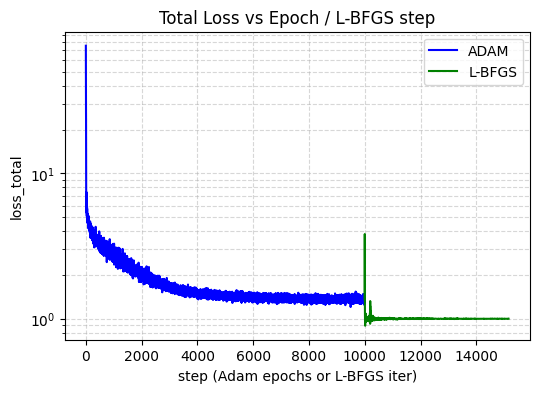

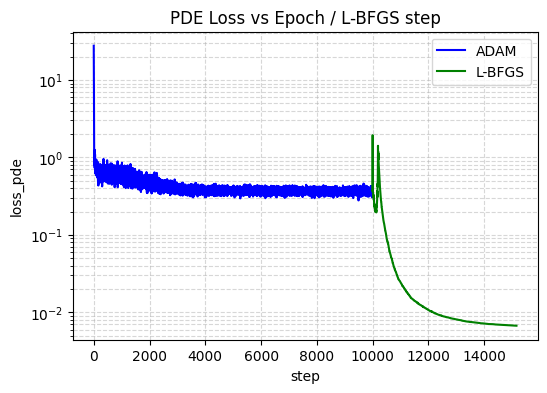

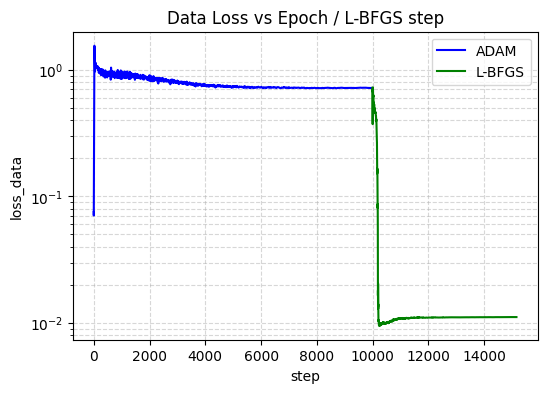

In [66]:
# Plotting three separate loss evolutions
n = min(n_epochs, len(total_history))
total_history = total_history + lbfgs_total
pde_history   = pde_history + lbfgs_pde
data_history   = data_history + lbfgs_data


# a) Total Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(n), total_history[:n], \
             color = 'blue', label = "ADAM")
plt.semilogy(np.arange(n, len(total_history)), total_history[n:], \
             color = 'green', label = "L-BFGS")
plt.title("Total Loss vs Epoch / L-BFGS step")
plt.xlabel("step (Adam epochs or L-BFGS iter)")
plt.ylabel("loss_total")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# b) PDE Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(n), pde_history[:n], \
             color = 'blue', label = "ADAM")
plt.semilogy(np.arange(n, len(pde_history)), pde_history[n:], \
             color = 'green', label = "L-BFGS")
plt.title("PDE Loss vs Epoch / L-BFGS step")
plt.xlabel("step")
plt.ylabel("loss_pde")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# c) Data Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(n), data_history[:n], \
             color = 'blue', label = "ADAM")
plt.semilogy(np.arange(n, len(data_history)), data_history[n:], \
             color = 'green', label = "L-BFGS")
plt.title("Data Loss vs Epoch / L-BFGS step")
plt.xlabel("step")
plt.ylabel("loss_data")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)


plt.show()
# # c) Data Loss with homotopy
# plt.figure(figsize=(6,4))
# plt.semilogy(np.arange(n_hom), data_history[:n_hom], \
#              color = 'blue', label = "ADAM with homotopy")
# plt.semilogy(np.arange(n_hom, n_epochs), data_history[n_hom: n_epochs], \
#              color = 'orange', label = "Adam on true PDE")
# plt.semilogy(np.arange(n_epochs, len(pde_history)), data_history[n_epochs:], \
#              color = 'green', label = "L-BFGS on true PDE")
# plt.title("Data Loss vs Epoch / L-BFGS step")
# plt.xlabel("step")
# plt.ylabel("loss_data")
# plt.legend()
# plt.grid(True, which="both", ls="--", alpha=0.5)
#plt.show()

### Learned Solution vs FEM Solution

In [67]:
#choose to load the model fine-tuned with lbfgs or just the one trained with adam
load_fine_tuned = True #set to False for Adam-only model
model = BoundaryPINN(power, width, depth)

if load_fine_tuned:
    model.load_state_dict(torch.load(lbfgs_model_path))
else:
    model.load_state_dict(torch.load(adam_model_path))
model.to(device)
model.eval()

BoundaryPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
)

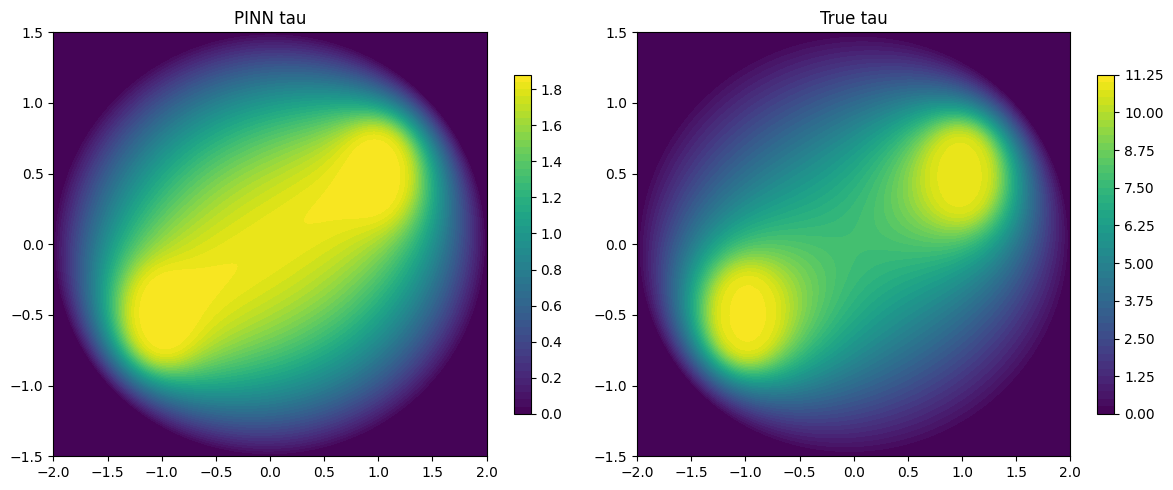

In [68]:
#Visualize PINN vs True tau

n_pts = 200
xx, yy = np.meshgrid(
    np.linspace(-a,a,n_pts),
    np.linspace(-b,b,n_pts)
)
mask = (xx/a)**2 + (yy/b)**2 <= 1.0
pts = np.vstack([xx[mask], yy[mask]]).T

with torch.no_grad():
    inp = torch.from_numpy(pts).to(device)
    pred = model(inp).cpu().numpy().squeeze(-1)

Zp = np.zeros_like(xx); Zt = np.zeros_like(xx)
Zp[mask] = pred
Zt[mask] = np.array([u_sol(x, y) for x, y in pts])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
cf1 = ax1.contourf(xx, yy, Zp, levels=50, cmap='viridis')
ax1.set_title('PINN tau')
fig.colorbar(cf1, ax=ax1, shrink=0.8)

cf2 = ax2.contourf(xx, yy, Zt, levels=50, cmap='viridis')
ax2.set_title('True tau')
fig.colorbar(cf2, ax=ax2, shrink=0.8)
plt.tight_layout()
plt.show()

### Relative and Pointwise error

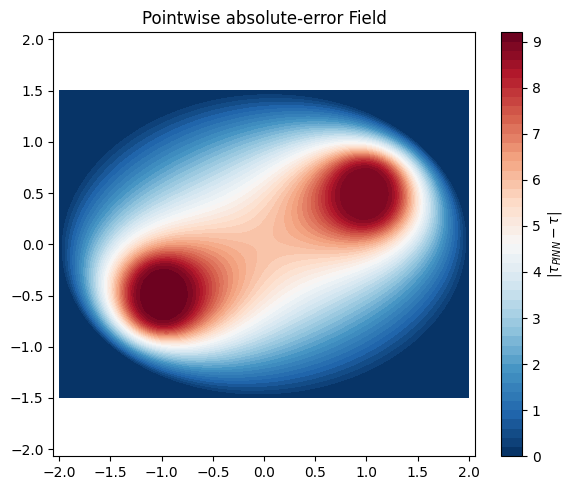

In [69]:
# pointwise L1 error
Z_err = np.abs(Zp - Zt)
plt.figure(figsize=(6,5))
cf = plt.contourf(xx, yy, Z_err, levels=50, cmap='RdBu_r')
plt.colorbar(cf, label=r'$|\tau_{PINN}-\tau|$')
plt.title('Pointwise absolute‐error Field')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [70]:
# average relative L2 error
#    ‖tau_pinn − tau_true‖₂ / ‖tau_true‖₂   (empirical L²(Ω) norm)
pred_vals = pred
true_vals = np.array([u_sol(x, y) for x, y in pts])

# Empirical L² norm of true solution: √( (1/n) Σ τ_true² )
tau_l2_norm = np.sqrt(np.mean(true_vals**2))
glob_rel_L2 = np.sqrt(np.mean((pred_vals - true_vals)**2)) / tau_l2_norm
print(f"Global relative L2 error: {glob_rel_L2:.3e} (true solution L2 norm: {tau_l2_norm:.3e})")

# average relative L1 error
#     ‖tau_pinn − tau_true‖_1 / ‖tau_true‖_1   (empirical L¹(Ω) norm)
tau_l1_norm = np.mean(np.abs(true_vals))
glob_rel_L1 = np.mean(np.abs(pred_vals - true_vals)) / tau_l1_norm
print(f"Global relative L1 error: {glob_rel_L1:.3e} (true solution L1 norm: {tau_l1_norm:.3e})")

print(f"Final PDE loss: {after_pde:.3e}")
print(f"Final data loss: {after_data:.3e}")

Global relative L2 error: 7.944e-01 (true solution L2 norm: 5.740e+00)
Global relative L1 error: 7.823e-01 (true solution L1 norm: 4.776e+00)
Final PDE loss: 6.732e-03
Final data loss: 1.113e-02
